# 1. Extract frames and preprocess data

In [ ]:
import os
import cv2

def extract_frames(video_path, output_folder, frames_per_second=3):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    interval = int(fps // frames_per_second)
    frame_count = 0
    extracted_count = 0
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        if frame_count % interval == 0:
            frame_filename = os.path.join(output_folder, f'frame_{extracted_count:04d}.jpg')
            cv2.imwrite(frame_filename, frame)
            extracted_count += 1
        
        frame_count += 1

    cap.release()
    print(f'Extracted {extracted_count} frames from {video_path}')

def process_videos(input_folder, output_base_folder, frames_per_second=3):
    categories = ['high-level violence', 'low-level violence', 'non-violence']
    for category in categories:
        category_path = os.path.join(input_folder, category)
        output_category_path = os.path.join(output_base_folder, f'{category}_frames')
        
        if not os.path.exists(output_category_path):
            os.makedirs(output_category_path)
        
        for video_file in os.listdir(category_path):
            if video_file.endswith(('.mp4', '.avi', '.mov')):
                video_path = os.path.join(category_path, video_file)
                video_name = os.path.splitext(video_file)[0]
                output_folder = os.path.join(output_category_path, video_name)
                extract_frames(video_path, output_folder, frames_per_second)

input_folder = 'D:/CNN-LSTM/violence-detection-dataset'
output_base_folder = 'D:/CNN-LSTM/violence-detection-dataset-frames'
frames_per_second = 3

process_videos(input_folder, output_base_folder, frames_per_second)

# 2. Training the model

In [21]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, Flatten, Dense, LSTM, TimeDistributed, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_curve, auc, roc_auc_score

def load_data(folders, labels, base_path, frame_count=10):
    data = []
    targets = []
    for folder in folders:
        folder_path = os.path.join(base_path, folder)
        for video_folder in os.listdir(folder_path):
            video_path = os.path.join(folder_path, video_folder)
            frames = []
            for frame_file in sorted(os.listdir(video_path))[:frame_count]:
                frame_path = os.path.join(video_path, frame_file)
                frame = cv2.imread(frame_path)
                frame = cv2.resize(frame, (64, 64))
                frames.append(frame)
            if len(frames) < frame_count:
                frames.extend([np.zeros_like(frames[0])]*(frame_count - len(frames)))
            data.append(frames)
            targets.append(labels[folder])
    return np.array(data), np.array(targets)

base_path = "D:\\CNN-LSTM\\violence-detection-dataset-frames"
folders = ["high-level violence_frames", "low-level violence_frames", "non-violence_frames"]
labels = {"high-level violence_frames": 0, "low-level violence_frames": 1, "non-violence_frames": 2}

data, targets = load_data(folders, labels, base_path)
data = data / 255.0

print(f"Data shape: {data.shape}")
print(f"Targets shape: {targets.shape}")


Data shape: (350, 10, 64, 64, 3)
Targets shape: (350,)


In [15]:
def create_model(input_shape, num_classes, conv_filters, lstm_units, dropout_rate=0.5):
    inputs = Input(shape=input_shape)
    x = Conv3D(conv_filters, (3, 3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling3D((2, 2, 2))(x)
    
    for _ in range(2):
        x = Conv3D(conv_filters, (3, 3, 3), activation='relu', padding='same')(x)
        x = MaxPooling3D((2, 2, 2))(x)
    
    x = TimeDistributed(Flatten())(x)
    x = LSTM(lstm_units)(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(256, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

input_shape = (10, 64, 64, 3)
num_classes = 3
conv_filters_list = [32, 64, 128]
lstm_units_list = [64, 128, 256]
results_neurons = {}

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
mean_fpr = np.linspace(0, 1, 100)

In [ ]:
for conv_filters in conv_filters_list:
    for lstm_units in lstm_units_list:
        f1_scores = []
        roc_aucs = []
        tprs = []
        histories = []

        for train_index, val_index in kf.split(data, targets):
            X_train, X_val = data[train_index], data[val_index]
            y_train, y_val = targets[train_index], targets[val_index]

            model = create_model(input_shape, num_classes, conv_filters, lstm_units)
            history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=16, callbacks=[early_stopping])
            histories.append(history.history)

            y_val_pred = model.predict(X_val)
            y_val_pred_classes = np.argmax(y_val_pred, axis=1)

            f1 = f1_score(y_val, y_val_pred_classes, average='weighted')
            f1_scores.append(f1)

            fpr, tpr, _ = roc_curve(y_val, y_val_pred_classes, pos_label=2)
            roc_auc = auc(fpr, tpr)
            roc_aucs.append(roc_auc)
            tprs.append(np.interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)

        results_neurons[f'conv_filters_{conv_filters}_lstm_units_{lstm_units}'] = {
            'histories': histories,
            'mean_f1_score': np.mean(f1_scores),
            'mean_auc': np.mean(roc_aucs),
            'mean_tpr': mean_tpr,
            'mean_fpr': mean_fpr,
            'mean_auc_curve': mean_auc
        }

        model.save(f'violence_detection_model_conv_{conv_filters}_lstm_{lstm_units}.h5')
        print(f"Model with conv_filters={conv_filters} and lstm_units={lstm_units} saved as 'violence_detection_model_conv_{conv_filters}_lstm_{lstm_units}.h5'")
        print(f"Average F1-Score: {np.mean(f1_scores):.4f}")
        print(f"Average AUC: {np.mean(roc_aucs):.4f}")

# 3. Plot the results

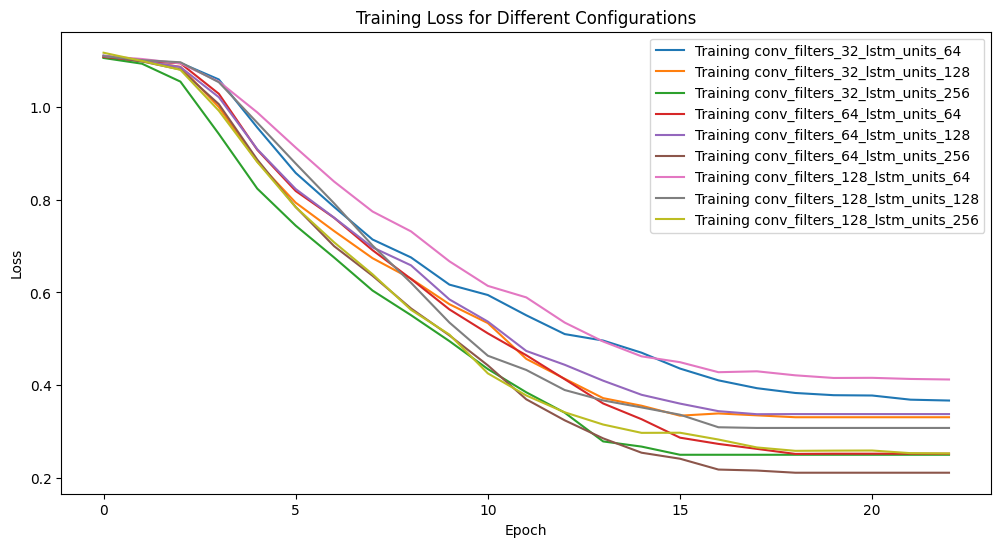

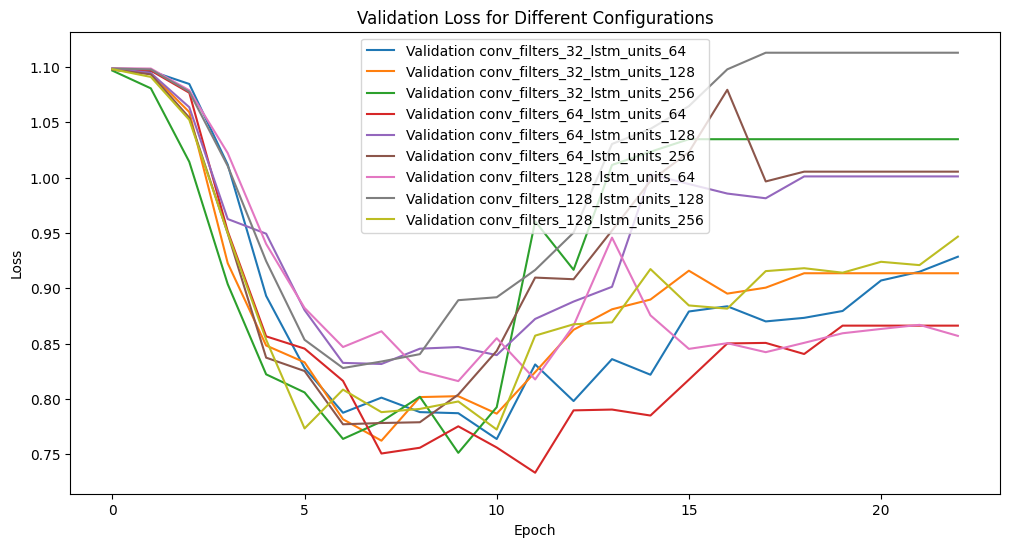

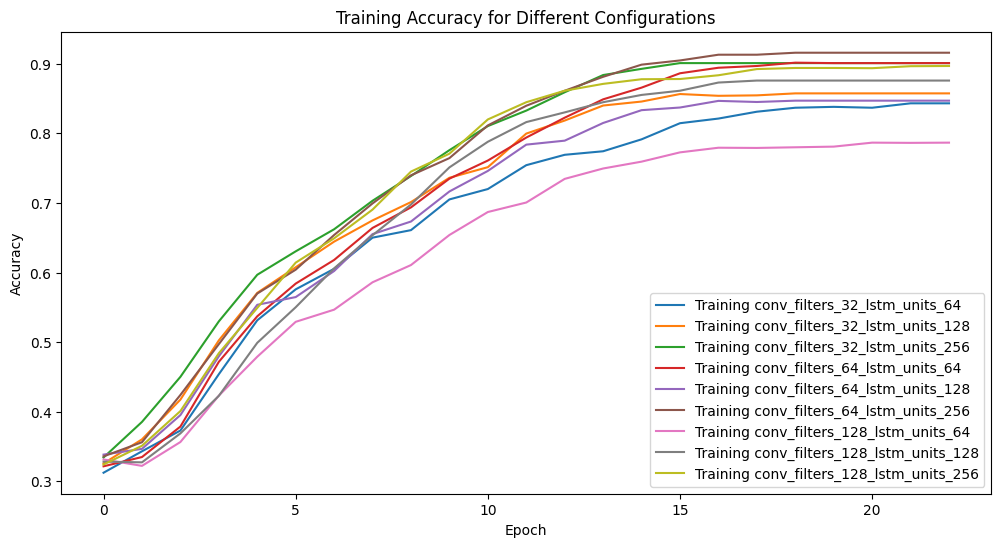

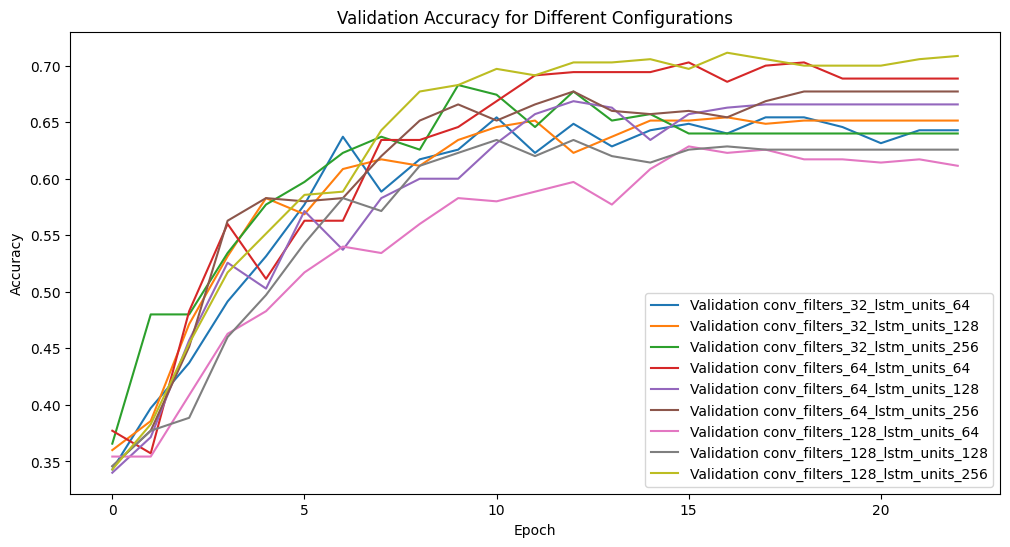

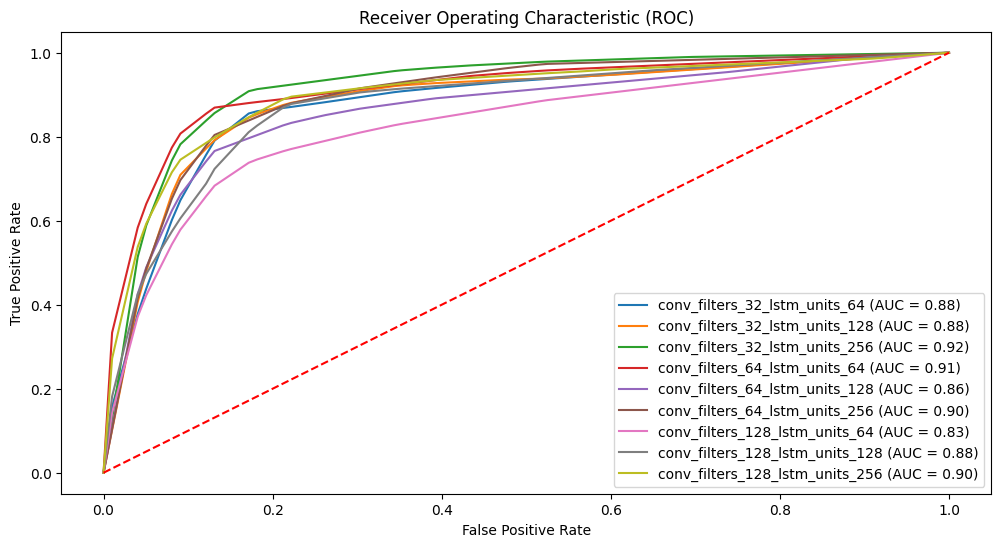

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Get the length of the longest history record
max_len = max([len(history['loss']) for key in results_neurons for history in results_neurons[key]['histories']])

# Define a function to pad history records
def pad_history(history, max_len):
    padded_history = {}
    for key in history:
        padded_history[key] = history[key] + [history[key][-1]] * (max_len - len(history[key]))
    return padded_history

# Pad all history records
padded_results_neurons = {}
for key in results_neurons:
    padded_histories = [pad_history(history, max_len) for history in results_neurons[key]['histories']]
    padded_results_neurons[key] = {
        'histories': padded_histories,
        'mean_fpr': results_neurons[key]['mean_fpr'],
        'mean_tpr': results_neurons[key]['mean_tpr'],
        'mean_auc_curve': results_neurons[key]['mean_auc_curve']
    }

# Plot training loss
plt.figure(figsize=(12, 6))
for key in padded_results_neurons:
    mean_loss = np.mean([history['loss'] for history in padded_results_neurons[key]['histories']], axis=0)
    plt.plot(mean_loss, label=f'Training {key}')
plt.title('Training Loss for Different Configurations')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot validation loss
plt.figure(figsize=(12, 6))
for key in padded_results_neurons:
    mean_val_loss = np.mean([history['val_loss'] for history in padded_results_neurons[key]['histories']], axis=0)
    plt.plot(mean_val_loss, label=f'Validation {key}')
plt.title('Validation Loss for Different Configurations')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training accuracy
plt.figure(figsize=(12, 6))
for key in padded_results_neurons:
    mean_accuracy = np.mean([history['accuracy'] for history in padded_results_neurons[key]['histories']], axis=0)
    plt.plot(mean_accuracy, label=f'Training {key}')
plt.title('Training Accuracy for Different Configurations')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot validation accuracy
plt.figure(figsize=(12, 6))
for key in padded_results_neurons:
    mean_val_accuracy = np.mean([history['val_accuracy'] for history in padded_results_neurons[key]['histories']], axis=0)
    plt.plot(mean_val_accuracy, label=f'Validation {key}')
plt.title('Validation Accuracy for Different Configurations')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot ROC curve
plt.figure(figsize=(12, 6))
for key in padded_results_neurons:
    mean_fpr = padded_results_neurons[key]['mean_fpr']
    mean_tpr = padded_results_neurons[key]['mean_tpr']
    mean_auc = padded_results_neurons[key]['mean_auc_curve']
    plt.plot(mean_fpr, mean_tpr, label=f'{key} (AUC = {mean_auc:.2f})')

plt.plot([0, 1], [0, 1], color='r', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()